# Implementing the Ahnert and Payne scheme for a general 1-qubit  POVM on qiskit.



## Introduction

### POVM

### Ahnert Payne

#### ![Image of Yaktocat](https://www.groundai.com/media/arxiv_projects/334479/POVM.png.750x0_q75_crop.png)

### Implementation, general idea

In [1]:
from numpy import pi
import numpy as np

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit.tools.visualization import circuit_drawer
from qiskit import Aer
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.visualization import plot_histogram


/home/jordan/workspace/qiskit/qiskit_venv/lib/python3.6/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


### Constructing a doubly controlled rotation gate

Before start constructing the Ahnert Payne POVM, we will create a quantum circuit performing a doubly controlled rotation on the target qubit, if the two control qubits are $ |1 \rangle$. The allowed rotations will be either z-only or y-only, unlike the qiskit u3() operation, which can perform general multi-axial rotation. However performing combinations of doubly-controlled z- and y-rotationns, we will be able to perform any doubly-controlled operation. We will need this operation when performing the t-branches operations.

Given a rotation axis $ i \in \{y,z\}$, angle $\theta$, control qubit $ q_{ctrl1}$ and $q_{ctrl2}$ and target qubit $  q_{target}$ we perform:
$ doubleCU1(i, \theta, q_{ctrl1}, q_{ctrl2}, q_{target}) =  C_{cx}(q_{ctrl1}, q_{ctrl2}, q_{target}) R_{i}( - \frac{\theta}{2}) C_{cx}(q_{ctrl1}, q_{ctrl2}, q_{target}) R_{i}(\frac{\theta}{2}) $   
where $C_{cx} $ is the Toffoli gate. 

The reasoning being, that if the two control bits are $ |1 \rangle$, the two Toffoli gate will effectively "flip" the sign of the $-\frac{\theta}{2}$ rotation hence it will add up the the first $\frac{\theta}{2}$ rotation, resulting in a total rotation of $ \theta $. Conversely if any of the control bits is not $ |1 \rangle$, the sign of the second rotation will not be flipped and both rotations will cancel out.  Note that this true only if perform single axis rotation.

In [39]:
# n-qubit control rotation gate

def nCU1(axis, angle, q_circ, ctrls, target):
    """
        Implements n-qubit controlled rotation (nCU1 )
        The rotation is single axial (unlike the qiskit multi axial rotation u3),
        Parameters:
        * axis: specifies the rotation, acceptable char values 'y' and 'z'
        (note: y and z rotation can be combined to implement any single qubit
        unitary operation)
        * angle: Bloch sphere angle specifying the rotation
        * q_circ: the quantum circuit to, which the nCU1 operation is added
        * ctrls: a list or quantum register of the control qubits.
        * target: the target qubit
    """
    n_ctrls = len(ctrls)
    list_ctrls = list(ctrls)  # a list of the qubits is easier to work with, than the QuantumRegister object
    new_ctrls = list_ctrls[:-1]  # take all control qubits references but the last one

    if n_ctrls >= 2:

        nCU1(axis, angle/2, q_circ, new_ctrls, target)
        q_circ.cx(list_ctrls[-1], target)
        nCU1(axis, -angle / 2, q_circ, new_ctrls, target)
        q_circ.cx(list_ctrls[-1], target)
    elif n_ctrls == 1:

        if axis == 'y':
            q_circ.cu3(angle, 0, 0, list_ctrls[0], target)
        elif axis == 'z':
            q_circ.cu3(0, 0, angle, list_ctrls[0], target)
        else:
            raise ValueError('Invalid value for axis!')
    else:

        if axis == 'y':
            q_circ.u3(angle, 0, 0, target)
        elif axis == 'z':
            q_circ.u3(0, 0, angle, target)
        else:
            raise ValueError('Invalid value for axis!')

    return 1

### 2 part POVM

In [55]:
# TODO: add phase rotations

def first_AP_module_new(qc, q, tita1, tita2, phi1, phi2):
    """ Implements a first module of Ahenrt Payne POVM.

        qc: existing q-circuit

        q: is a register of at least 3 qubit objects.
        q[0] represents the state being measured 
        q[1] is ancilla qubit, used to represent the output branches. It should be in the zero state
        q[2], is another ancilla qubit, required for intermidiate operations. It should be in zero state too
        
        The outputs (branches) correspond to the following values of q1:
            branch p1: 0
            branch p2: 1

        tita1 and tita2 specify POVMs 1 and 2(see above)
        (future version will allow for phase operations, specified by phi1 and phi2)
    """

    # Split in paths p1 and p2
    qc.cx(q[0],q[1])
#     qc.barrier(q)  # use barriers to print the circuit accuratly later
    # Apply the rotations along p1 and p2

    # controlled rotation if qubit 1 is ZERO
    qc.x(q[1])
    qc.cu3(2*(tita1 + pi/2),0,0,q[1],q[0])
    qc.x(q[1])
#     qc.barrier(q)

    # controlled rotation if qubit 1 is ONE
    qc.cu3(2*tita2,0,0,q[1],q[0])
#     qc.barrier(q)

   # Now instead of t branching swap the second ancilla qubit
#     qc.swap(q[0],q[1])
    
    qc.cx(q[0],q[1])
    qc.cx(q[1],q[0])
    qc.cx(q[0],q[1])

    qc.x(q[1])
    qc.z(q[1]) #u3(0,0,pi,q[1])  # not sure if neccessery for the correct output!!!
#     qc.barrier(q)
    
    # phase shifts:
    qc.x(q[1])
    qc.cu3(0,0,phi2,q[1], q[0])
    qc.x(q[1])
    
    qc.cu3(0,0,phi2,q[1], q[0])

## Testing 

/home/jordan/workspace/qiskit/qiskit_venv/lib/python3.6/site-packages/qiskit/tools/visualization/_circuit_visualization.py:206: DeprecationWarning: The current behavior for the default output will change in a future release. Instead of trying latex and falling back to mpl on failure it will just use "text" by default
  '"text" by default', DeprecationWarning)


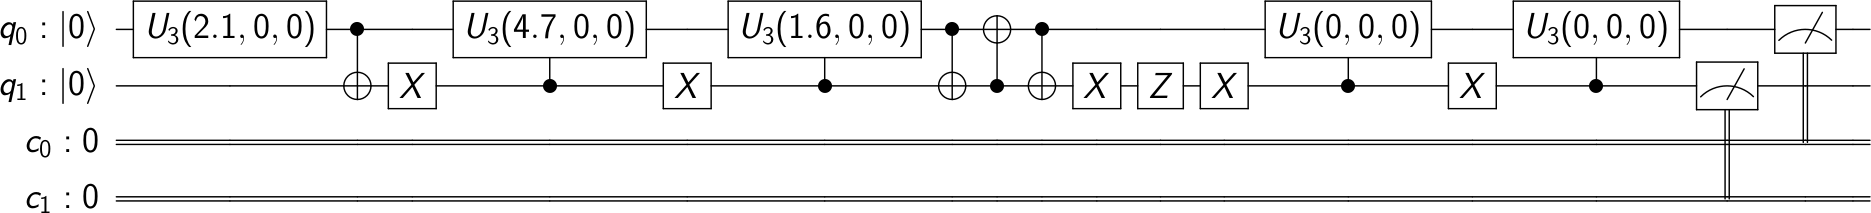

In [56]:
# Create a Quantum Register with 3 qubits.
q = QuantumRegister(2, 'q')

# Create a Quantum Circuit acting on the q register
qc = QuantumCircuit(q)


# Add waiting time
# for i in range(10000):
#     qc.iden(q)


# prepare the input state (the input state will be represented by qubit 0)
qc.u3(pi*2/3, 0 ,0, q[0])
# qc.barrier(q)

# Apply the POVM
first_AP_module_new(qc,q,pi/4,pi/4, 0, 0)

# Add Measurements

# Create a Classical Register with 3 bits.
c = ClassicalRegister(2, 'c')
# Create a Quantum Circuit
meas = QuantumCircuit(q, c)
# meas.barrier(q)
# map the quantum measurement to the classical bits
meas.measure(q,c)

# The Qiskit circuit object supports composition using
# the addition operator.
qc = qc+meas

circuit_drawer(qc)


### Run the simulator

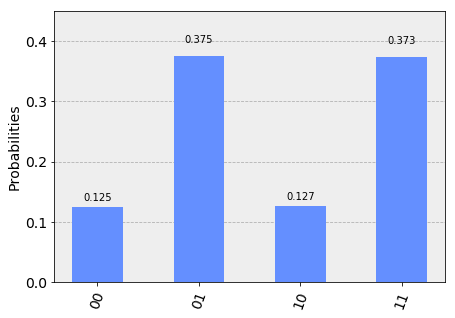

In [57]:
# Run the quantum circuit on a simulator backend
backend = Aer.get_backend('qasm_simulator')
shots = 8096

# Create a Quantum Program for execution 
job = execute(qc, backend, shots = shots)

# execute
result = job.result()

counts = result.get_counts(qc)
plot_histogram(counts)

### REAL DEVICE EXPERIMENT


In [60]:
# IBMQ.save_account(token)
IBMQ.load_accounts()


shots = 8192           # Number of shots to run the program (experiment); maximum is 8192 shots.
max_credits = 10       # Maximum number of credits to spend on executions. 
n_qubits = 3


# large_enough_devices = IBMQ.backends(filters=lambda x: x.configuration()['n_qubits'] == 5 and not x.configuration()['simulator'])
# backend = least_busy(large_enough_devices)

backend = IBMQ.backends(name='ibmqx2')[0]
# backend = IBMQ.backends(filters=lambda x: x.name == 'ibmqx5')
print("The best backend is " + backend.name())

/home/jordan/workspace/qiskit/qiskit_venv/lib/python3.6/site-packages/qiskit/providers/ibmq/ibmqprovider.py:251: UserWarning: Credentials are already in use.
  warnings.warn('Credentials are already in use.')


The best backend is ibmqx2


In [63]:
# <<<<<<<<<<< EXECUTING real experiment >>>>>>>>>>>>>>
run = 1  # keep 0 untill you want to run the experiment, to avoid running by mistake. It is slow and cost credits!
if run:
    job_exp = execute(qc, backend=backend, shots=shots, max_credits=max_credits)
    result = job_exp.result()

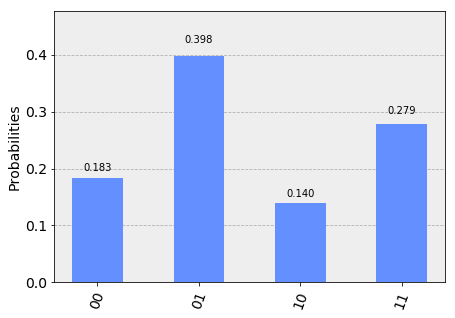

In [64]:
counts = result.get_counts(qc)
plot_histogram(counts)

### 3 Part POVM

#### General idea

#### Implementation


In [66]:
# TODO: add phase rotations

def second_AP_module_new(qc, q, tita3, tita4):
    """ Implements a second module of Ahenrt Payne POVM.

        qc: existing q-circuit

        q: is a register of at least 4 qubit objects.
        q[0] represents the state being measured 
        q[1], q[2] are ancilla qubits, used to represent the output branches. They should be in the zero state
        q[3], is another ancilla qubit, required for intermidiate operations. It should be in zero state too
        
        The outputs (branches) correspond to the following values of q1q2:
            branch p1: 00
            branch p2: 10
            branch p3: 11

        tita3 and tita4 specify POVMs 3 and 4(see above)
        (future version will allow for phase operations, specified by phi2 and phi3)
    """

    # Split in branches p3 and p4
    qc.ccx(q[0],q[1],q[2])
    
    # Apply the rotations along p1' and p2'

    # Rotation along p1' branch
    qc.x(q[2])
    nCU1('y', 2*(tita3 + pi/2), qc,[q[1], q[2]],q[0])
    qc.x(q[2])

    # rotation along p2' branch
    nCU1('y', 2*tita4,qc ,[q[1], q[2]],q[0])

    # instead of t branchin c-swap q0 and q2 if q1
    qc.cswap(q[1],q[0],q[2])
    qc.cx(q[1],q[2])
    qc.cu3(0,0,pi,q[1],q[2])


#### Example:

As an example we implement the popular case of nonorthogonal 3 part POVM along axes separated by $ 120^o $ in the $ xz $ plane of the Block sphere. 

In [67]:
# angle parameters for the 1st and 2nd panel
tita1 = np.arccos(np.sqrt(2/3))
tita2 = pi/2
tita3 = 0
tita4 = pi/2

# Ui and Uii are implemented as controled rotations as well. 
# In our example Ui = I, so no action needed
# For Uii required y rotation at -pi/2 rads 

alpha_ui = 0
alpha_uii = -pi/2

In [68]:
# Create a Quantum Register with 4 qubits.
q = QuantumRegister(3, 'q')

# Create a Quantum Circuit acting on the q register
qc = QuantumCircuit(q)

# qc.u3(0, 0, 0, q[0])  # INITIAL STATE!

# Apply Ui
# qc.u3(alpha_ui, 0, 0, q[0])  # for the sake of clarity

# Apply the 1st AnP panel
first_AP_module_new(qc,q,tita1,tita2,0,0)
    
# Apply Uii, require a single qubit controled rotation 
nCU1('y', alpha_uii, qc, [q[1]], q[0])     

# Apply 2nd Ahnert Payne POVM module
second_AP_module_new(qc, q, tita3, tita4)




At this point we have obtained the desired POVMs $F_1, F_2$ and $F_3$. However they do not completerly define the measurement operators $ M_1, M_2 $ and $ M_3 $. To fully specify the measurements we need to perform $ T_1 , T_2, T_3 $ unitary operations to each of the 3 outputs. 

In the case of three measurements corresponding to axes $ 120^o$ apart, one of which is along the $z_+$ axis we need to perform the following T operations:

(this is wrong)

$ T_1 = I = \left( \begin{smallmatrix} 1&0\\ 0&1 \end{smallmatrix} \right)$ , $ T_2 = \frac{1}{2} \left( \begin{smallmatrix} 1& -\sqrt{3}\\ \sqrt{3}&1 \end{smallmatrix} \right)$,  $ T_3 = \frac{1}{2} \left( \begin{smallmatrix} 1& \sqrt{3}\\ -\sqrt{3}&1 \end{smallmatrix} \right)$ 

To perform this operations we use our n-qubit controled rotation. We perform y-axis rotation at angles $ 0 ,\frac{2\pi}{3}, \frac{-2\pi}{3} $ respectevely, with control qubits $ { q_1, q_2 } $ and target qubit $ q_0 $. Again we use X gates to tackle the values of the control qubits. 


In [18]:
# perform T2 on p2 branch, correspond to 10 value of q1q2
qc.x(q[2])
# nCU1('y', 2*pi/3, qc, [q[1], q[2]], q[0] )
nCU1('y', 2*pi/3, qc, [q[1], q[2]], q[0] )
qc.x(q[2])

# perform T3 on p3 branch, correspond to 11 value of q1q2
# nCU1('y', -2*pi/3, qc, [q[1], q[2]], q[0] )  # changee???
nCU1('y', 7*pi/3, qc, [q[1], q[2]], q[0] )

# 11->01
qc.cx(q[2],q[1])

/home/jordan/workspace/qiskit/qiskit_venv/lib/python3.6/site-packages/qiskit/tools/visualization/_circuit_visualization.py:206: DeprecationWarning: The current behavior for the default output will change in a future release. Instead of trying latex and falling back to mpl on failure it will just use "text" by default
  '"text" by default', DeprecationWarning)
WARNING Unable to compile latex. The output from the pdflatex command can be found in latex_error.log


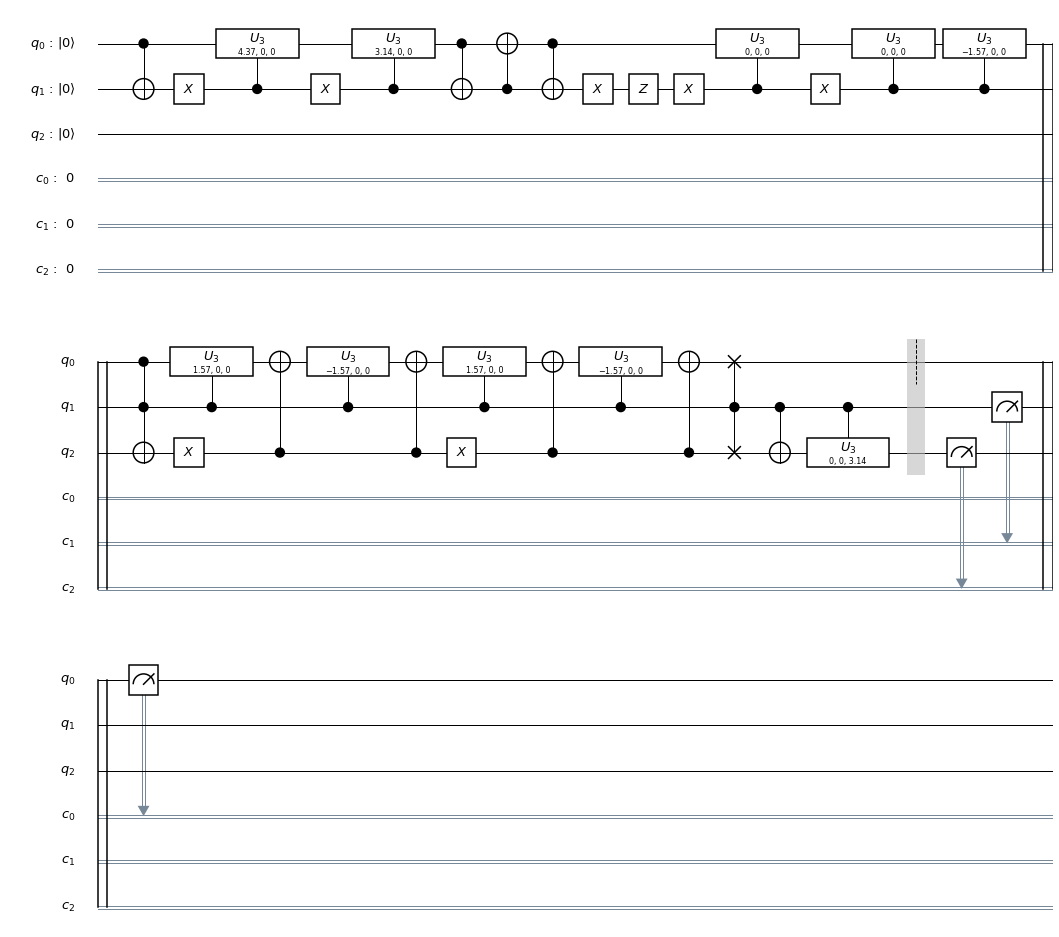

In [69]:
# Add Measurements

# Create a Classical Register with 3 bits.
c = ClassicalRegister(3, 'c')
# Create a Quantum Circuit
meas = QuantumCircuit(q, c)
meas.barrier(q)
# map the quantum measurement to the classical bits
meas.measure(q,c)

# The Qiskit circuit object supports composition using
# the addition operator.
qc = qc+meas

circuit_drawer(qc)

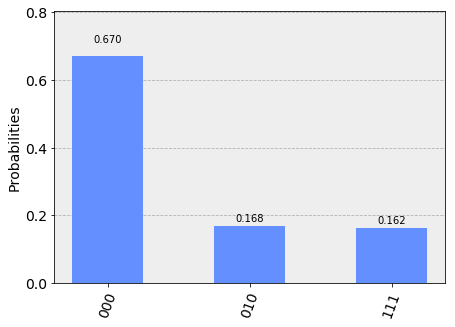

In [70]:
# Run the quantum circuit on a simulator backend
backend = Aer.get_backend('qasm_simulator')
shots = 8096

# Create a Quantum Program for execution 
job = execute(qc, backend, shots = shots)

# execute
result = job.result()

counts = result.get_counts(qc)
plot_histogram(counts)

In [71]:
# IBMQ.save_account(token)
IBMQ.load_accounts()


shots = 8192           # Number of shots to run the program (experiment); maximum is 8192 shots.
max_credits = 10       # Maximum number of credits to spend on executions. 
n_qubits = 3


# large_enough_devices = IBMQ.backends(filters=lambda x: x.configuration()['n_qubits'] >= n_qubits and
#                                                        not x.configuration()['simulator'])
# backend = least_busy(large_enough_devices)
backend = IBMQ.backends(name = 'ibmqx2')[0]
print("The best backend is " + backend.name())

/home/jordan/workspace/qiskit/qiskit_venv/lib/python3.6/site-packages/qiskit/providers/ibmq/ibmqprovider.py:251: UserWarning: Credentials are already in use.
  warnings.warn('Credentials are already in use.')


The best backend is ibmqx2


In [ ]:
# Hello there
# <<<<<<<<<<< EXECUTING real experiment >>>>>>>>>>>>>>
run = 1  # keep 0 untill you want to run the experiment, to avoid running by mistake. It is slow and cost credits!
if run:
    job_exp = execute(qc, backend=backend, shots=shots, max_credits=max_credits)
    result = job_exp.result()

In [ ]:
counts = result.get_counts(qc)
plot_histogram(counts)

In [94]:
counts5 =counts
counts5

{'0x3': 954,
 '0x2': 901,
 '0x1': 1173,
 '0x0': 1623,
 '0x7': 737,
 '0x6': 931,
 '0x5': 865,
 '0x4': 1008}

In [90]:
counts5, counts4, counts3, counts2, counts1

({'0x3': 927,
  '0x2': 926,
  '0x1': 1150,
  '0x0': 1559,
  '0x7': 764,
  '0x6': 984,
  '0x5': 850,
  '0x4': 1032},
 {'0x3': 887,
  '0x2': 807,
  '0x1': 1168,
  '0x0': 1710,
  '0x7': 744,
  '0x6': 1013,
  '0x5': 889,
  '0x4': 974},
 {'0x3': 931,
  '0x2': 763,
  '0x1': 1161,
  '0x0': 1720,
  '0x7': 658,
  '0x6': 925,
  '0x5': 931,
  '0x4': 1103},
 {'0x3': 930,
  '0x2': 818,
  '0x1': 1134,
  '0x0': 1694,
  '0x7': 781,
  '0x6': 958,
  '0x5': 827,
  '0x4': 1050})

In [96]:
counts1['0x1']

1134

In [102]:
final = {}
for i in [0,1,2,3,4,5,6,7]:
    final[str(i)] = counts1['0x'+str(i)] +  counts2['0x'+str(i)]+  counts3['0x'+str(i)]+  counts4['0x'+str(i)]+  counts5['0x'+str(i)]

In [105]:
final= {'000': 8306,
 '001': 5786,
 '010': 4215,
 '011': 4629,
 '100': 5167,
 '101': 4362,
 '110': 4811,
 '111': 3684}

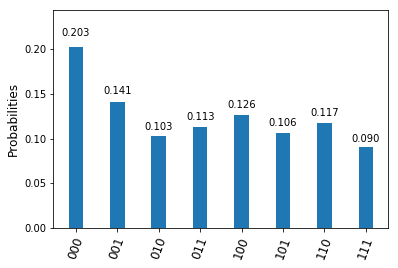

In [106]:
plot_histogram(final)